#### Fatih Enes Usta 319552979 Classification of Political Writings by using LSTM

In [1]:
pip install transformers

     |████████████████████████████████| 675kB 4.3MB/s 
     |████████████████████████████████| 890kB 10.5MB/s 
     |████████████████████████████████| 3.8MB 19.5MB/s 
     |████████████████████████████████| 1.1MB 44.0MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893260 sha256=60a743ab6a457a45411aeffd02e9e5903ab57c18b984a29a5a136c42b54e0bde
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [2]:
import pandas as pd
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.tokenize import RegexpTokenizer
from nltk.tokenize import word_tokenize
import string
import nltk
import numpy as np
import torch
import re
from bs4 import BeautifulSoup
import requests
from sklearn import metrics
import transformers
from transformers import AutoModel, AutoTokenizer, BertTokenizer
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Embedding
from keras.layers import SpatialDropout1D
from keras.models import Sequential
from keras.layers.recurrent import LSTM
from keras.layers import Dense, Activation
from keras.callbacks import EarlyStopping
from keras.optimizers import SGD
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import statistics 
from keras.utils import to_categorical

Using TensorFlow backend.


In [0]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
link = 'https://drive.google.com/open?id=1dbVPCgtw5VUOck-ZwYwsto3ZVqOd6wNB'
fluff, id = link.split('=')
import pandas as pd
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('03_06_nlp_data_latest.xlsx')  

In [0]:
mainData = pd.read_excel("03_06_nlp_data_latest.xlsx")
labels = mainData[['Labels']]

In [5]:
mainData.Labels.value_counts()

0    2523
1    2503
Name: Labels, dtype: int64

In [75]:
mainData[10:20]

,Unnamed: 0,index,Articles,Labels,Cleaned_Articles,Bert_Stemmed_Tokenized
10,10,4598,"<div class=""newsBox"">\n<p>FETÖ bu milletin ver...",0,fetö bu milletin vergileriyle alınan silahlarl...,"[feto, bu, milletin, vergileri, alınan, silahl..."
11,11,4599,"<div class=""newsBox"">\n<p>Deniz Baykal, ""<b>yü...",0,"deniz baykal, ""yüzde 50 oyla anayasa yapılmaz""...","[deniz, baykal, "", yuzde, 50, oyla, anayasa, y..."
12,12,4600,"<div class=""newsBox"">\n<p>Konya Milletvekili A...",0,"konya milletvekili ahmet davutoğlu, başbakanlı...","[konya, milletvekili, ahmet, davut, basbakan, ..."
13,13,4601,"<div class=""newsBox"">\n<p>Soru şudur: <b>2'nci...",0,soru şudur: 2'nci dünya savaşı'nda bile ülkemi...,"[soru, sudur, :, 2, nci, dunya, savas, nda, bi..."
14,14,4602,"<div class=""newsBox"">\n<p>Bu hafta, uluslarara...",0,"bu hafta, uluslararası ve yurtiçi piyasalar he...","[bu, hafta, uluslararası, ve, yurti, piyasalar..."
15,15,4603,"<div class=""newsBox"">\n<p><img alt="""" src=""htt...",0,şaşırdınız değil mi? yaa... haberiniz yokken b...,"[sas, degil, mi, yaa, ., ., ., haberiniz, yokk..."
16,16,4604,"<div class=""newsBox"">\n<p>Ne diyordu Orhan Sey...",0,"ne diyordu orhan seyfi orhon?\r""diyorlar, kül ...","[ne, diyordu, orhan, seyfi, orhon, "", diyorlar..."
17,17,4606,"<div class=""newsBox"">\n<p><strong>K</strong><b...",0,"kadir has üniversitesi, türk dış politikası ka...","[kadir, has, universitesi, turk, dıs, politika..."
18,18,4607,"<div class=""newsBox"">\n<h2>ADANA</h2>\n<p>Çuku...",0,adanaçukurova bölge temsilcimiz ersin ramoğlu'...,"[adana, bolg, temsilcimiz, ersin, ram, na, "", ..."
19,19,4608,"<div class=""newsBox"">\n<p>3 gündür Cumhurbaşka...",0,3 gündür cumhurbaşkanımız recep tayyip erdoğan...,"[3, gundur, cumhurbas, recep, tayyip, erdogan,..."


##### I will be using Bert Tokenizer for tokenization & stemming

In [0]:
mainData['Cleaned_Articles'] = [str(i).lower() for i in mainData['Cleaned_Articles']]


In [7]:
mainData.iloc[0]

Unnamed: 0                                                          0
index                                                               0
Articles            Bu ülkede iflah olmaz bir kafa var. Onlar ne d...
Labels                                                              0
Cleaned_Articles    bu ülkede iflah olmaz bir kafa var. onlar ne d...
Name: 0, dtype: object

In [8]:
mainData.loc[10]

Unnamed: 0                                                         10
index                                                            4598
Articles            <div class="newsBox">\n<p>FETÖ bu milletin ver...
Labels                                                              0
Cleaned_Articles    fetö bu milletin vergileriyle alınan silahlarl...
Name: 10, dtype: object

In [9]:
mainData.loc[3800]

Unnamed: 0                                                       3800
index                                                            2559
Articles            [<div class="author-the-content content-elemen...
Labels                                                              1
Cleaned_Articles     saygı öztürk, kaz dağları’ndaki katliamı yeri...
Name: 3800, dtype: object

In [10]:
tokenizer_bert = BertTokenizer.from_pretrained("dbmdz/bert-base-turkish-128k-uncased")
#model = AutoModel.from_pretrained("dbmdz/bert-base-turkish-128k-cased")

/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils.py:831: FutureWarning: Parameter max_len is deprecated and will be removed in a future release. Use model_max_length instead.
  category=FutureWarning,


In [0]:
def wordpieces(x):
    willCleaned = tokenizer_bert.tokenize(x)
    clean = []
    tokens = [",","’","?","(",")","'","*","!"]
    for element in willCleaned:
        if element not in tokens:
            if not "#" in element:
                clean.append(element)
    return clean

In [0]:
mainData['Bert_Stemmed_Tokenized'] = [wordpieces(str(i)) for i in mainData['Cleaned_Articles']]

##### Example of supporter

##### Labeled 0

In [13]:
mainData['Cleaned_Articles'][0]

'bu ülkede iflah olmaz bir kafa var. onlar ne deprem dinliyor, ne şehitlerimize saygı duyuyor ne de küresel bir salgına dönüşen koronavirüs onları durdurabiliyor. libya’da şehit düşen mi̇t görevlilerinin mezar taşlarını bile yayınlamaktan çekinmediler. bu ülkede en büyük istismar ise atatürkçülük adına yapılan atatürk istismarı oluyor.atatürk’ün harbiye’ye girişinin 121. yıldönümü törenlerine milli savunma bakanı hulusi akar ve kuvvet komutanları katıldı. atatürk’ün harbiye’deki öğrenci numarası olan 1283 okunduğunda, harp okulu öğrencileri ayağa kalkarak i̇çimizde dedi. bu tören sosyal medya organlarından da canlı olarak yayınlandı. görüntü dikkatle incelendiğinde ayağa kalkmayanların olduğu görülüyor. bunun üzerine hemen bir karşı saldırı başladı. vay bazı harp okulu öğrencileri ayağa kalkmamış, vay efendim bunlarla ilgili kayıt tutulup işlem yapılmış mı...bunu bizim savunma muhabirlerimizin hepsi bilir. ben de 90’lı yıllarda harp okulu’ndaki töreni izlemiş bir gazeteciyim. atatürk’ü

##### Example of against

#### Labeled 1

In [14]:
mainData['Cleaned_Articles'][3800]

" saygı öztürk, kaz dağları’ndaki katliamı yerinde inceledi, yazdı…kaz dağları'ndaki manzarayı görmeye yürek dayanmıyor. çanakkale belediye başkan yardımcısı ünüvar 40'a yakın şirket ruhsatlandırılmış durumda. onlar da katliama başlayacak uyarısını yapıyor. ‘su ve vicdan nöbetleri' ise giderek büyüyor. pazar günkü nöbete herkesi çağırıyorlar.edremitli akın andıç'ı hemşerileri kaz dağları sevdalısı, o ise kendisini kaz dağları delisi olarak tanımlar. ormanına, havasına, suyuna sahip çıkar, yeri gelince tek kişilik eylemini başlatır. birlikte ormanların katledildiği bölgeye giderken, hepimiz iyiliğimiz kadar aydınlatıyoruz dünyayı. kimimiz fener, kimimiz mum kadar  diyor.bir çeşme başında duruyoruz. 24 haziran 1934'te atatürk,i̇ran şahı rıza pehlevi'ye modern türkiye'nin simgesi olarak göstereceği balıkesir-çanakkale yolunda, bu çeşme başında dinleniyorlar. kirazlı yayla balaban tepesinde kahve içiyorlar. gölgesinde kahve içilen ağaç kurumuş olsa da, sarmaşıklar o ağacı canlı gibi göster

## Long Short Term Memory

In [15]:
maximum_words_number = 58161
maximum_length = 50000
e_dim = 100
tokenizer = Tokenizer(num_words=maximum_words_number, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=False)
tokenizer.fit_on_texts(mainData['Bert_Stemmed_Tokenized'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 55759 unique tokens.


In [0]:
X = tokenizer.texts_to_sequences(mainData['Bert_Stemmed_Tokenized'].values)

##### An example of how X looks like after using texts to sequence (encoded words into numbers)

In [17]:
X[0]

[4,
 451,
 18164,
 538,
 2,
 1433,
 25,
 1,
 430,
 14,
 1100,
 8961,
 14,
 444,
 1561,
 7099,
 14,
 7,
 291,
 2,
 344,
 250,
 134,
 826,
 6950,
 1,
 854,
 6,
 444,
 93,
 1114,
 124,
 4070,
 2231,
 44,
 13513,
 195,
 1,
 4,
 451,
 22,
 29,
 3293,
 42,
 120,
 547,
 213,
 120,
 9759,
 413,
 1,
 120,
 88,
 6174,
 53,
 902,
 11530,
 1,
 69,
 915,
 197,
 717,
 269,
 4481,
 2728,
 3,
 3900,
 8718,
 1532,
 1,
 120,
 88,
 6174,
 264,
 623,
 6300,
 33,
 9222,
 11966,
 3054,
 2708,
 623,
 2478,
 19363,
 360,
 152,
 1,
 4,
 915,
 228,
 424,
 31976,
 6,
 1062,
 21,
 3901,
 1,
 664,
 3253,
 6175,
 2478,
 17141,
 66,
 147,
 1,
 166,
 232,
 273,
 2,
 23,
 1892,
 178,
 1,
 3725,
 199,
 3054,
 2708,
 623,
 2478,
 11127,
 3725,
 1794,
 4536,
 162,
 2607,
 24138,
 977,
 1248,
 77,
 1,
 1,
 1,
 155,
 171,
 717,
 16253,
 601,
 1570,
 1,
 110,
 7,
 1538,
 2078,
 1128,
 3054,
 2708,
 2378,
 915,
 7574,
 2,
 8719,
 1,
 120,
 88,
 6300,
 11966,
 378,
 6174,
 3947,
 17,
 12434,
 3902,
 3,
 607,
 1117,
 17,
 360,

##### An example of how X looks after padding

In [0]:
X = pad_sequences(X, maxlen=maximum_length)

In [19]:
X[0]

array([ 0,  0,  0, ..., 37,  1, 87], dtype=int32)

##### This is our target(label)

In [0]:
Y = mainData['Labels'].values

In [21]:
Y

array([0, 0, 0, ..., 1, 1, 1])

##### Changing target to a binary array

In [0]:
y_binary = to_categorical(Y)

In [23]:
y_binary

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [0., 1.],
       [0., 1.],
       [0., 1.]], dtype=float32)

##### Let's look how many values of supporters and against we have before feeding into our model

In [24]:
X_train, X_test, Y_train, Y_test = train_test_split(X,y_binary, test_size = 0.5, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(2513, 50000) (2513, 2)
(2513, 50000) (2513, 2)


In [25]:
model = Sequential()
model.add(Embedding(maximum_words_number, e_dim, input_length=X.shape[1]))
model.add(SpatialDropout1D(1))
model.add(LSTM(5, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(2, activation='softmax'))
#opt = SGD(lr=0.05)
model.compile(loss='categorical_crossentropy', optimizer="Nadam", metrics=['accuracy'])
epochs = 3
batch_size = 100
model_outcome = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.5,callbacks=[EarlyStopping(monitor='val_loss', patience=1, min_delta=0.0001)])



/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 1256 samples, validate on 1257 samples
Epoch 1/3
1256/1256 [==============================] - 3677s 3s/step - loss: 0.6875 - accuracy: 0.5780 - val_loss: 0.6798 - val_accuracy: 0.6054
Epoch 2/3
1256/1256 [==============================] - 3495s 3s/step - loss: 0.6382 - accuracy: 0.7309 - val_loss: 0.6342 - val_accuracy: 0.7009
Epoch 3/3
1256/1256 [==============================] - 3568s 3s/step - loss: 0.4604 - accuracy: 0.9172 - val_loss: 0.5507 - val_accuracy: 0.7422


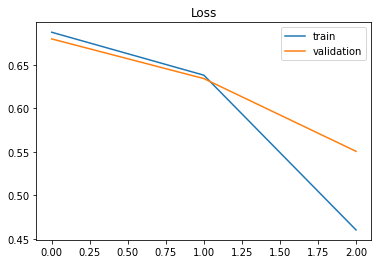

In [26]:
plt.title('Loss')
plt.plot(model_outcome.history['loss'], label='train')
plt.plot(model_outcome.history['val_loss'], label='validation')
plt.legend()
plt.show();

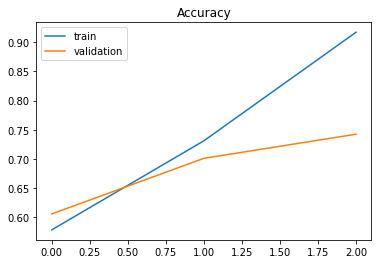

In [27]:
plt.title('Accuracy')
plt.plot(model_outcome.history['accuracy'], label='train')
plt.plot(model_outcome.history['val_accuracy'], label='validation')
plt.legend()
plt.show();

### Test Data

In [0]:
lstmpredict = model.predict(X_test)

In [29]:
y_pred = (lstmpredict > 0.5) 
print("Accuracy score of testing is:", accuracy_score(Y_test,y_pred))

Accuracy score of testing is: 0.7508953442101074


#### Confusion Matrix

In [0]:
y_pred_binary = np.where(y_pred > 0.5, 1., 0.)

In [31]:
confusion_matrix(Y_test.argmax(axis=1), y_pred_binary.argmax(axis=1))

array([[1193,  103],
       [ 523,  694]])

#### F1 Score

In [32]:
f1_score(Y_test.argmax(axis=1), y_pred_binary.argmax(axis=1), average='binary')

0.6891757696127111

# Some news examples from internet 

In [0]:
def prediction(x):
    dfa = {'col1': [x]}
    dfab = pd.DataFrame(data=dfa)
    dfab = dfab.applymap(str.lower)
    dfab['text'] = [wordpieces(str(i)) for i in dfab['col1']]
    tokenize_abc = tokenizer.texts_to_sequences(dfab['text'])
    tokenize_abc_padded = pad_sequences(tokenize_abc, maxlen=maximum_length)
    abc_predict= model.predict(tokenize_abc_padded)
    return abc_predict


### These examples are mostly supporters of the current ruling party and mostly against CHP

###### Talks about CHP and IYI Parti and also associates them with PKK and HDP

In [34]:
prediction("Komik tabii ki. Hayır yani, başka biri yok muydu o açıklamayı yapacak? Yoktuysa, ihtiyaca binaen müttefikinizden isteseydiniz ya! Meral Hanım, ordan bir adet milletvekili göndersen; bir açıklama yapacağız da... Olmaz mı? İllaki Grup Başkanvekili düzeyinde mi olması gerekiyor? E siz de haklısınız. CHP olarak, İP ve PKKnın siyasi kanadı HDPyle birlik olup Libyayla yapılan uluslararası anlaşmaya ret oyu verdiğinizi düz bir milletvekilinin açıklaması hiç yakışık almazdı. Peki, günübirlik de olsa İPten bir adet grup başkan vekili isteyemez miydiniz? Yetişmez miydi? O vakit bıraksaydınız da ittifakla aldığınız mahut kararı İP açıklasaydı. Denizdeki Sevri paramparça eden Libyayla yaptığımız söz konusu anlaşmaya HDPyle birlikte ret oyu verdiklerini (tabanlarına izah edemeyecekleri için) açıklamaktan imtina mı ederlerdi? Tüm müstevlilerin karşı çıktığı (Libya ile imzaladığımız) Deniz Yetki Alanlarının Sınırlandırılmasına İlişkin Mutabakat Muhtırasına karşı CHP ve İPle birlikte ret oyu kullandıklarını nasıl unutturacaklar peki? Size ne mi dediniz, tamam, sonuç itibarıyla onda da haklısınız. Demek ki kala kala CHP Grup Başkan Vekili Engin Altaya mı kaldınız! Ama bu da nerden bakarsanız bakın komik. Bu hükümet dünyanın en doğru işini bile yapsa bizim bu hükümeti alkışlayacak halimiz yok... diyebilen bir insan evladının açıklamasından ne çıkar. Gelgelelim, Kılıçdaroğlu ondan daha az komik değil. Libyada ne işimiz var dedi iyi mi? Sınırlarımızda terör devleti kurulmaması için yapılan Barış Pınarı Harekatı üzerine de Ne işimiz var Suriyede demişti. Bütün bunlar, küresel iktidar yandaşı olmanın doğal sonucudur. Küresel iktidara muhalif olanlar harici ve dahili bedhahların her operasyonuna hazırlıklı olmak zorundadırlar. Yeni Samanyolu TV tesmiye ettiğim FOX TVnin Portakalı emekli amirallerimizden Cem Gürdenizin Kanal İstanbul projesi hakkındaki (teşrih masasına yatırılmaya değer) çekincelerini tıpkı eski Samanyolu TV gibi araçsallaştırdı. FETÖ de algı operatörleriyle askeri vesayeti araçsallaştırarak Balyoz kumpasını gerçekleştirmişti. Portakal adlı o algı operatörü hepsinden daha maharetli. O kadar ki, hem amiralimiz Gürdenizi Balyoz mağduru diye sunuyor, hem de o kumpası gerçekleştirenleri her fırsatta arkalayabiliyor. Zaten araçsallaştırmanın dışında Cem Gürdeniz dahil hiçbir Balyoz mağduru zerre miskali umurunda olmaz. Şayet olsaydı, mesela, Barış Pınarı Harekâtı hakkında Cem Gürdenizin görüşlerine başvurmak yerine, kafam karışık diyerek başlattığı algı operasyonuyla Mehmetçiği adeta her akşam arkasından hançerlemezdi. Hadi şimdi başvursun Cem Gürdenizin görüşlerine de görelim. CHP, İP ve HDPnin ret oyu verdiği Libyaya yaptığımız malum anlaşmanın milat olduğunu, Türkiyenin bu muhtırayla Sevri parçaladığını, KKTC dışında bir ülke ile ilk kez münhasır ekonomik bölgenin batı sınırını bu anlaşma sayesinde çizdiğimizi ve artık üstünlüğün Türkiyeye geçtiğini söylüyor. Söyleşi yapmasından geçtim, amiralimizin bu görüşlerini bile aktaramaz. İşi gücü yalan dolan, işi gücü manipülasyon pornosu yaparak haberleri çarpıtmak. Bazen keşke CHP Genel Başkanı bu çocuk olsaydı diyorum, en azından taşlar yerine otururdu.")

array([[0.8300294 , 0.16997051]], dtype=float32)

###### Talks about the leader of the CHP and critizes them

In [35]:
prediction("Hatırlarsanız, Gezi ve Mısır’daki darbe eş zamanlı olarak yürürlüğe konmuştu. Biz kazandık. Mısır ise çapulculara ve orduya teslim oldu. O sırada skandallar kraliçesi CHP’li prof Gaye Usluer şöyle demişti: Seçimle geldik diyen Mursi üç günde gitti... Buradan da anlıyoruz ki, CHP’lilerin demokrasi tarifinde sandık o kadar da mühim bir yer işgal etmiyor. Hatta, hiç yer işgal etmiyor... Demokrasi, evet, sadece sandık demek değildir ama seçimle geldiğini söyleyip, en azından o makamda bulunuşunun meşruiyetine atıf yapan seçilmiş bir başkanın arkasından üç günde gitti diyerek zil takıp oynamak da değildir. Koskoca prof böyle diyecek de, CHP Genel Başkan Yardımcısı Umut Oran geri kalacak... Mümkün mü? Buyurun kendi ağzından dinleyelim: Mısır’daki gelişmeler çok önemli. Demokrasinin sadece sandıkla olmadığının bir göstergesi. Tüm siyasi kurumlar ders çıkarmalı... Güzel, değil mi? Fakat, Umut Oran, yarattığı güzelliğin peşinden gitmiyor. Yani, sözünün arkasında durmuyor. Mısır’dan ordu yönetime el koydu haberi gelince, yazdığı tweeti siliyor ve hemen yenisini devreye sokuyor: Demokrasi sadece sandık değildir ve darbeler asla kabul edilemez. Çoğulcu, özgür bir ülkede yaşamak herkesin hakkı... Bunu o zaman söyleyecektin Umut Oran... İş işten geçmiş ve demokrasi sadece sandık değildir düşüncesi askeri darbeye varmış, sen kalkmış içinde çoğulculuk, özgürlük geçen hoş ama boş cümleler kuruyorsun. Hadi Umut Oran hafiften de olsa nedamet getiriyor, darbeci demesinler diye yazdığı tweeti siliyor ve kendince iz bırakmıyor. Kemal Kılıçdaroğlu’nun iz bırakmamak gibi bir derdi de yok. Bilakis iz oluştursun istiyor ve bodoslamadan dalıyor. Kendisi anlatsın: Demokrasiyi sadece sandıktan ibaret sayanların yanıldıklarını görüyoruz. Çoğulculuk denen bir kavram var. Herkesin taleplerine, ülkeyi yönetenlerin kulak kabartması gerekiyor. Taleplere duyarsız kalmak, onları görmezden gelmek, ‘benim oy çokluğum vardır, ben istediğimi yaparım’ demek artık günümüzde geçerli değildir. Kemal Bey, belli ki, çoğunluk-çoğulculuk meselesine atıf yapıyor. Peki, Köprü yapmayacaksın, havaalanı açmayacaksın, enerji santrallerini iptal edeceksin, Kanal İstanbul projesinden vazgeçeceksin, Topçu Kışlası’nı aklından bile geçirmeyeceksin, hemen şu an istifanı verip gideceksin ültimatomu hangi çoğulculuk düşüncesinin ürünüdür? Demokrasi sandık demek değildir. Tamam... Demokrasi, beledi hizmetlerin mütemadiyen bir azınlık tarafından engellenmesi midir? Demokrasi sandık demek değildir. Tamam... Demokrasi, sandıkla gelmiş bir iktidarı sokak nümayişleriyle, askeri darbeyle alaşağı etmeye çalışmak mıdır? Demokrasi sandık demek değildir. Tamam... Demokrasi, şartlar olgunlaştığında darbenin meşru hak olduğunu söylemek midir? Kemal Kılıçdaroğlu, Can Dündar’ın, Şartlar olgunlaştığında darbe meşru hak mıdır? sorusuna hayır diyememiş, mırın kırın ederek zımnen bunun hak olabileceğini belirtmiş bir siyasetçidir. Kemal Kılıçdaroğlu budur. Kemal Kılıçdaroğlu, Gezi Parkı nümayişleri sırasında (yani 5 Haziran’da) Gezi Parkı için referandum yapılsın demiş, bu açıklamasından bir hafta sonra (yani 13 Haziran’da) Biz referanduma karşıyız diyerek, kendisine ait çark rekorunu egale etmiş bir siyasetçidir. Kemal Kılıçdaroğlu budur. CHP budur.")

array([[0.6444375, 0.3555625]], dtype=float32)

###### Talks about main opposition party

In [48]:
prediction("Ana muhalefet partisinin kökleri geçmişe uzanan çok ciddi bir açmazı var. Ne olursa olsun toplumun çoğunluğunun desteğini alamıyor. Oyları -çok partili devirdeki rekorunu kırarak yüzde 413 aldığı- 1977 seçiminden bu yana yüzde 25in üzerine hiç çıkmadı. Bu duruma çözüm olarak iki farklı siyaset önerisi tartışılır durur CHPde yıllardır. Bunlardan biri partiyi merkezde konumlayarak toplumun bütününe ulaşabilmeyi temin etme fikri. Diğeri partiyi sola çekerek toplumun çoğunluğunu oluşturan emekçi kitlelerin desteğini alma yaklaşımı. Bu iki görüşün de sahipleri diğer görüşün sahiplerini partinin oy almasına engel olmakla suçlarlar öteden beri. Galiba problem hem sol hem de merkez kavramlarının Türkiyedeki karşılıklarının belirsizliğinde. İkinci Dünya Savaşı sonrasında çok partili hayata geçişimizin ardından Demokrat Parti iktidarları devrinde gerçekleşen büyük transformasyon neticesinde siyasi ve toplumsal merkezin hızla daralması üzerine merkez partisi kimliğini terk edip İsmet Paşanın ağzından ortanın solunda yer aldığını açıklamıştı CHP. Bu hamlenin ideolojik bir tercih değil toplumsal ve politik konjonktürün icabı olduğunu kabul etmek istemeyenlerin tartışmasıdır CHPdeki merkez-sol tartışması. Partideki sol kanat Türkiyenin sosyolojik gerçekleri yerine Marksist literatürün ezberlerini siyasetinin temeline koyduğu için halka ulaşamadı. Halka ulaşılamadı çünkü SHP adı altında faaliyet gösterilen bu dönemde salon solculuğunun ötesine geçilmedi. (Bugünkü HDPnin atası olan HEPin kurucularının katkısı ise Kürt asıllı seçmen tabanını siyasetin ana gövdesinden koparıp uzaklaştırması oldu.) Sol kanat Ecevitin 1977de aldığı rekor oyu o dönemde CHPnin gecekondulara ulaşılmış olmasına bağlıyordu. Mamafih kendileri ne gecekonduya ulaşmak için gayret gösterdiler ne de Ecevitin aldığı oyda Kıbrıs fatihi oluşunun etkisini hesaba kattılar. *** Buna mukabil partinin sola açılmasının yanlış merkeze yönelmesinin doğru siyaset olduğunu düşünenlerin ise merkezinde problem vardı. 1980 öncesinin merkezcileri enikonu tarihdışı bir yaklaşımla ideolojik merkezi toplumsal merkezin yerine ikame etme hayalciliğine kapılmışlardı. Daha da kötüsü bu merkezci gruplar CHPyi bir siyasi parti olarak görmüyor asker ve sivil bürokrasinin devlet üzerindeki hakimiyetinin yardımcı unsurlarından biri sayıyorlardı. Dolayısıyla halktan oy almak ve iktidara gelmek (çünkü fikirleri her daim iktidardaydı) gibi düşünceleri ve arayışları yoktu. CHPnin gerçek anlamda siyasi parti gibi davranmaya başlaması -SHP tecrübesini saymazsak- Deniz Baykal döneminin hadisesidir. Ancak Baykal hem partideki merkezci yapıyı aşamadı hem de parti dışındaki tarihi müttefiklerinin kendisini sürüklemesine engel olamadı. Pragmatist ve yüksek iletişim kabiliyetine sahip -ama yetiştiği dönem itibarıyla demokratik hassasiyetleri zayıf- bir siyasetçi olarak gördüğümüz Baykaldan sonra CHPnin başına geçen Kemal Kılıçdaroğlu sessiz sakin mizacıyla pek ümit vermiyordu parti tabanına. Ama kısa zamanda partiye hâkim olup bunca zamandır da liderliğine bir alternatif çıkmamış olması kim ne derse desin attığı adımların isabetli oluşuyla ilgili. Kılıçdaroğlunun en büyük başarısı herhalde İstanbul ve Ankara belediyelerini bir bakıma çeyrek asır sonra AK Partinin elinden almış olması. Ama bu başarıyı partisinin oylarını arttırarak değil fonksiyonel bir muhalefet bloğu inşa edip muhalif seçmenin kimi yerde aralarındaki ideolojik uçurumlara rağmen ortak hareket etmesini sağlayarak elde etti. CHP lideri partisinin probleminin sağla solla merkezle ilgili olmadığının farkında. Daha doğrusu sağ sol merkez gibi kavramları hayatın ve toplumun gerçeklerinin önüne geçirmenin siyasi başarı getirmediğinin farkında. *** Toplumun sağına soluna değil tümüne ulaşabilmesi gerektiğini parti politikası haline getirmeye uğraşan Kılıçdaroğluna en önemli destek ise kendi partisinden değil rakibi Erdoğandan geldi. AK Parti liderinin ihdas ettiği başkanlık rejiminin seçim sisteminde yüzde elli+bir oy alma zorunluğu ittifakların önünü açtı ve bilhassa iktidarın dışlayıcı dilinin de etkisiyle hiç umulmayan bir sonuç ortaya çıktı. Tabiri caizse beş benzemez İstanbul ve Ankarayı iktidar partisinin elinden almakla kalmadı önümüzdeki cumhurbaşkanlığı seçimi için de mümkün senaryoları ortaya çıkarmış oldu. Bunun en önemli sonuçlarından biri Kılıçdaroğlunun partisindeki etkisinin kökleşmesi ve CHP liderinin siyasi stratejisinin adeta doktrin değeri kazanması olacak gibi görünüyor. Nitekim Fikret Bilanın T24te yazdığına göre CHP yeni bir parti programı hazırlığı içinde. Önümüzdeki genel kongreye yetişecek yeni programda CHPye oy versin veya vermesin her kesimle diyalog kurulması ve mevcut koşullarda Demokratlar İttifakının oluşturulması politikası ve uygulaması siyaset ilkesi olarak Kılıçdaroğlu yaklaşımı adı altında yer alacak. Bu demektir ki siyasi konjonktürün gerektirdiği geçici bir çözüm gibi görünen Kılıçdaroğlu yaklaşımı -CHPyi muhalefet bloğunun merkezine yerleştirme başarısı sayesinde- kalıcı bir parti ilkesine dönüşmüş olacak. Bu da partinin bundan sonra toplum kesimleriyle kuracağı ilişkinin ve geliştireceği diyaloğun yönünü belirleyecek. Ancak CHP genel başkanından veya onun danışmanları ile kurmay kadrosundan ibaret bir yapı değil. Tavandan da tabandan da buna karşı direniş olacaktır. Dolayısıyla Kılıçdaroğlunun dışarıda kazandığı mücadelenin benzerini kendi içinde kazanması çok daha zor olacaktır. Bekleyip göreceğiz.")

array([[0.6809493 , 0.31905073]], dtype=float32)

###### Criticizing Ekrem İmamoglu in a really harsh way.

In [36]:
prediction("Densizin biri (bu densiz İBB Başkanı mıdır, bürokratlar mıdır yoksa bürokratların görevlendirdiği bir ajans mıdır, bilemedim), ilkokul çocukları için bir broşür hazırlatıyor. Broşürün tirajı 100 bin... Çocuklarımız okuyacak, böylece, Ekrem İmamoğlu marifetiyle demokrasilerde sandığın yeterli olmadığını öğrenecekler. Olmadı, sokağa çıkacaklar... Broşürdeki ilgili sayfaya bakıyoruz. Ne görüyoruz? İki adet Abdullah... (Ressamın çiziminden ikisini de kolayca teşhis edebiliyorsunuz.) İlki Abdullah Öcalan; kaş, göz, pos bıyık yerli yerinde... İkincisi, süzme badem bıyığı, mütebessim çehresi ve George Coloney’den aparılmış saç tarama şekliyle Abdullah Gül... Bu iki (benzetilmiş) Abdullah, azgın bir kalabalığın önünde Başkan şaşırma, sabrımızı taşırma diye slogan atarak yürüyor... Hayır, hem benzetilmiş Abdullah’lar, hem de azgın kalabalığı oluşturanlar çocuk değiller, hele 23 Nisan çocuğu hiç değiller, koca koca adamlar. Buradaki Başkan kimdir? Cumhurbaşkanı Erdoğan dışında biri midir? İBB Başkanı olmadığına göre, muhayyel bir kişilik midir? Bunu da bilemedik. İBB Başkanı belli ki ilkokul çocuklarına 23 Nisan mesajı veriyor. Şunu demeye çalışıyor: Demokrasilerde sandığın yeterli olmadığını artık biliyorsunuz. İcabı halinde Gezi nümayişinde olduğu gibi sokağa çıkabilir, sabrınızı taşıran Başkanla hesaplaşabilirsiniz. Hayır, abartmıyorum... Bu tıynette, bu zihniyette adamlar bunlar... Bitti mi? Biter mi hiç? Asıl bombayı sona sakladım. Broşürün ilgili (yahut ilgisiz) sayfalarından birinde dört (rakamla 4) din adamı resmedilmiş. Resimlerin üzerinde temsil ettikleri dinin ismi yazıyor. Sırasıyla aktarıyorum: İslamiyet, Hıristiyanlık, Alevilik, Yahudilik... İBB Başkanı İmamoğlu burada, muhtemelen dinler (dört kutsal din) arasındaki ortaklığa yahut kardeşliğe vurgu yapıyor... Fakat bir dakika! Üç kutsal dini ve kitabını biliyoruz da, dördüncü kutsal din olan Aleviliği söktüremedik! Nasıl bir dindir bu? Peygamberi kimdir? Kutsal kitabı (yani yazılı öğretisi) nedir? Bu dinin müntesipleri dünyanın hangi eylem ve boylamında yaşamaktadır? Bizim bildiğimiz Alevilik İslam dairesinin içindedir. Yani Aleviler (dinin ritüellerini yerine getirenler vardır, getirmeyenler vardır, tıpkı Sünnilerde olduğu gibi) Müslüman’dırlar... Haa... Alisiz Alevilik gibi alçakça ve şerefsizce çalışma yürütenler, Aleviliği İslam dairesinin dışına çıkarmaya çalışan Alman köpekleri vardır; onların kim olduğunu ve nasıl bir çalışma yürüttüklerini biliyorsunuz. Aralarında bol miktarda CHP’li var... İsimlerine kısa bir Google taramasıyla ulaşabilirsiniz. (İBB yahut ajansı Alisiz Alevilik çalışmasının neresindedir? Bu konuda bizi temin etme görevi İBB’nin terli ve sevimsiz Başkanına düşüyor.) Burada beni düşündüren Kemal Kılıçdaroğlu’nun pozisyonu oldu. İBB Başkanı’na göre (daha doğrusu hazırlattığı broşüre göre) Alevilik özerk bir inanç ve İslamiyet dairesinin dışında. Dolayısıyla, bir Alevi olarak Kılıçdaroğlu da İslamiyet dairesinin dışında. Broşür skandalı ortaya çıktığı andan itibaren Kemal KIlıçdaroğlu’nun tepkilerini izliyorum Bugüne kadar bir açıklama yapmadı. Hayır, kimin haddine Aleviliği İslam dışı göstermek? demedi. Sırıttı... Sadece sırıttı... Sadece sırıtsa... Terli yamağı gibi, yalanlarına ve manipülasyonlarına devam etti.")

array([[0.82310414, 0.17689592]], dtype=float32)

###### Talks about Kemalizm, fetö and coup

In [37]:
prediction("Kemalist ve ulusalcı bilinen arkadaşlar Yeni darbeyi ulusalcılar yapacak iddiasına çok bozuluyor. Özetle Artık akıllandık darbelerin çözüm olmadığını öğrendik bizden geçti filan diyorlar. (Aslında demiyorlar. Diyebileceklerini varsayıyoruz.) İsteseler de darbe yapamazlarmış. Çünkü Ergenekon ve Balyoz soruşturmalarıyla hem güç hem de mevzi kaybetmişler. Demek ki mevzi kaybetmeseydiler verdikleri garantinin bir karşılığı olmayacaktı. Böyle mi anlamalıyız? Peki gerekli güce ulaştıktan ve mevzi tahkimatı yaptıktan sonra darbeye kalkışırlar mı? Bunun cevabını ben vermeyeyim... Herhangi bir haber kanalını açın FETÖ konulu açık oturumlardan birini izleyin özellikle de konuklardan Kemalist bilinenine kulak kesilin... Herhangi bir Kemalist olabilir fark etmez... Bir Ergenekon ve Balyoz mağduru olarak FETÖ’den çok çektiğini hain 15 Temmuz girişimini kınadığını Fetullah Gülen’in bir CIA ajanı olduğunu söyleyecektir. Peşinden FETÖ’cülerden ve CHP’lilerden duymaya alışık olduğumuz itiraz cümlelerini sıralayıp saldırıya geçecektir. Bazen haber kanallarında ismi Ahmet olan emekli bir paşaya rast geliyorum. Tartışma programlarının kadrolu Kemalist’i... Öyle ateşli öyle celadetli öyle öfkeli bir arkadaş ki... Konuşurken ağzından köpükler saçıyor. Makul başlıyor makul şeyler söylüyor Fetullah Gülen’in hainliğinden girip CIA taşeronluğundan çıkıyor ama söz Cumhurbaşkanı Erdoğan’a gelince birden halet değiştiriyor Kemalist cenahın tükettiği ne kadar anakronik malzeme varsa (din devletine gidiyoruz eyvah irtica geliyor her yanı başörtülü kapladı) hepsini boca ediyor... Öyle ateşli ki gerekli güce ulaşsa ve mevzi tahkimatı yapsa hemen darbeye stüdyoda kalkışacakmış gibi... Anlıyorsunuz ki ne kadar akıllandık deseler de her zaman aç bir tarafları var ve darbeye aşerdiklerini gizleyemiyorlar. En acıklısı da şu: FETÖ darbesini yargılarken acayip millî (daha doğrusu ulusalcı) görüntü veriyorlar millî ve yerli olmamayı neredeyse en büyük eksiklik sayıyorlar ama kendi darbelerine aynı gözle bakmıyorlar. İlk ulusalcı darbemiz 27 Mayıs’tı. Haklarını teslim edelim... Toplu kat- liam yapmadılar Meclis’i bombalamadılar tanklarını halkın üzerine sürmediler ama Başbakan astılar. Bol bol da bayrak gösterdiler... Bayraklarla süslü tanklarını bulvarlarda gezdirdiler embedded gazetecilerine devrim çığlıkları attırdılar ama NATO’ya ve CENTO’ya bağlılıklarını bildirmeyi de ihmal etmediler. Dolayısıyla 27 Mayıs millî kılıfı giydirilmiş bir NATO darbesidir en az FETÖ’nünkü kadar alçak bir girişimdir. (Bunu darbeci Sami Küçük anılarında anlatıyor. NATO görevim bitip Türkiye’ye indiğim gün darbe çalışmalarına başladık diyor.) 12 Mart da bir NATO darbesidir. Darbeciler sivil iradeyi bertaraf ettikten sonra CHP’den ödünç aldıkları Nihat Erim’e bir teknokratlar hükümeti kurdurdular. Hükümetin ilk icraatı Amerika’nın talebi doğrultusunda haşhaş ekimini yasaklamak ve U-2 casusluk uçuşlarına izin vermek oldu. 12 Eylül’le 28 Şubat’ın nerelerde kotarıldığını bilmeyene kız bile vermiyorlar. İkisi de Amerika-NATO darbesidir. İlki JUSMATT’ta ikincisi ABD Dışişleri Bakanlığı’nda kotarılmıştır. Kemalist bir darbe olursa hiç şüphesiz bu da bir Amerika-NATO darbesi olacaktır. Peki bu darbe ne zaman gündeme gelir? Çok basit: Kemalistler (İlhan Selçuk’un ifadesiyle) Güzel Amerikayı keşfettiğinde Güzel Amerika da bunların kullanıma hazır hale geldiğine inandığında...")

array([[0.77226967, 0.22773036]], dtype=float32)

##### The world's most ignorant, but also the worst men have gathered in the CHP ... More seriously, the party is also a tool of FETÖ organization ...

In [38]:
prediction("Dünyanın en cahil aynı zamanda en kötü adamları CHP’de toplaşmış durumda... Daha vahimi şu: Parti ayrıca bir FETÖ aparatı... ")

array([[0.8533111 , 0.14668894]], dtype=float32)

### Now, we will look at the against of the current ruling party

###### First starts with corona after critizes AKP because of they still do not accept the outcomes of the elections. (Istanbul and Ankara municipalities now being controlled by the main opposition party) 

In [39]:
prediction("Korona salgını ile birlikte tüm dünyada ezberler bozuldu. İnternetin insan hayatına girmesiyle başlayan değişim korona salgınıyla iyice vites artırdı. İnsanların birbirleriyle ilişkileri işçinin işverenle ilişkisi vatandaşın devletle ilişkisi sermaye yapısı tedarik zincirleri tüm kurallar yeniden yazılmaya başlandı. Türkiye ne internet çağından ne de korona salgınından elbette muaf değil. Toplumda değişim başladı. Ancak yönetim AKP hükümeti bu büyük değişimi görmezden geliyor yokmuş gibi davranıyor. İşte örnekler: – Korona ile birlikte kahraman tanımı da değişmeye başladı. Artık ülkeyi koruyan askerlerden çok insanı koruyan sağlık çalışanları kahraman olarak görülüyor. Ancak AKP hükümeti kahramanların büyük çoğunluğunun temsil edildiği Türk Tabipleri Birliğini yok saymaya kendi kurduğu Bilim Kurulunun bile tavsiyelerini dinlemekte direnmeye devam ediyor. – Küreselleşmeden yerele dönüş başladı. Salgın nüfus yoğunluğuna coğrafi koşullara bağlı olarak her yerde aynı şekilde baş göstermiyor. Binlerce kişinin enfekte olduğu ve olmaya devam ettiği nüfus yoğunluğu fazla büyük şehirler ile daha küçük yerleşim yerleri salgını çok farklı yaşıyorlar. Elbette buna göre de yerel önlem almak önem kazanıyor. Ancak AKP hükümeti büyük şehirlerin çoğunda seçimi muhalefet kazandı diye hâlâ merkezi önlem silsilesinde ısrara devam ediyor. Yerelin sesi hiç duyulmuyor alınacak önlemler Saraydaki tek kişinin uzmanlığına hayat görüşüne bilgi ve görgüsüne insafına bırakılmış durumda. Belediye başkanlarının -sırf muhalefet partisinden oldukları için- bağış toplayıp halka ulaştırmalarına bile yasak konuluyor. (Ancak bu arada hükümete yakın dernek ve vakıfların özgürce bağış toplamasının önü açılıyor.) AKP hükümeti enfekte olan bölgeler için özel önlemler almak yerine tüm Türkiyeyi kapsayan 65 yaş üstü ya da 20 yaş altı sokağa çıkma yasakları gibi -yarım yamalak- kararlarla önlem alıyormuş gibi görünmeye çalışıyor. – Salgınla birlikte ağırlık kazanan küreselden yerele dönüş eğilimi ekonomiyi de derinden etkiledi. Tedarik zincirleri sekteye uğrayınca kendi kendine yetmek doktrini ağırlık kazandı. Ancak Türkiye özeline bakıldığında acı gerçek ortaya çıktı; AKPnin son 18 yıllık yanlış tarım ve sanayi politikaları bir dönem kendi kendine yetebilen Türkiyeyi zaten darmadağın etmişti. Salgın döneminde zararın neresinden dönülse kârdır demelerini tarım ve sanayiyi kurtarmak için önlem almalarını beklerken AKP hükümeti yine tek bildiği -ve sevdiği- rant kapısına ağırlık verdi; inşaat sektörü. Gözler o kadar karartılmış olmalı ki tüm Türkiye can derdindeyken AKP hükümeti Kanal İstanbul gibi tek getirisi bir grup insanı zengin edecek proje için ihale yapmaktan bile kaçınmadı. – Devletin her alanda ağırlığı artmaya başladı. Salgınla birlikte piyasa ekonomisi kendini çeviremez hale gelirken devletin hem ekonomi hem de insan hayatı üzerindeki etkinliği artmaya başladı. Piyasa ekonomisinin bayraktarlığını yapan Almanya gibi Kanada gibi ülkeler salgın karşısında çalışamayan işçilere de işverenlere de pek çok güvence getirdi. Serbest piyasanın kralı ABD bile bu akımdan bigane kalamadı: Amerikanın en piyasacı Başkanı Donald Trump imzasıyla tüm ABD vatandaşlarına devlet kesesinden para dağıtıldı. Trump fakirler için sağlık sigortası getirdi diye yerden yere vurduğu bir önceki Başkan Obamanın politikalarının çok önüne geçen önlemlere imza atmak zorunda kaldı… Korona testi ABDde ücretsiz yapıldı. Şimdi tedavi masraflarının da Amerikan devletince üstlenilmesi üzerinde çalışılıyor. Dünyada devlet vatandaşına mali destek verirken Cumhurbaşkanı Erdoğan çıkıp halktan para istedi. Bitmedi… AKP hükümeti salgınla mücadele kapsamında sokağa çıkan herkese maske zorunluluğu getirirken vatandaşlarına bu zorunlu maskeleri ücretsiz vermeyi aklına bile getirmedi. Korona ile mücadele kapsamında AKP hükümetinin bir kanadı sürekli Erdoğanın bağış kampanyasında kaç para toplandığına ilişkin övünç dolu açıklamalar yaparken -o bağışların büyük kısmı da devlet kurumlarından bu arada. Para devletin bir cebinden çıkarılıp diğerine konuluyor- AKP hükümetinin Ticaret Bakanı çıkıp maskeleri uygun bir fiyatla satacaklarını açıklamaktan imtina etmedi. Ücretsiz maske dağıtma işi de vatandaştan bağış toplaması yasaklanan CHPli büyükşehir belediyelerine ihale edildi. Kısacası… Devlet mekanizmasına ve orduya kendi dönemlerinde yerleştirilen FETÖcülerin yaptığı darbeye karşı halka savunma çağrısı yapan… Depreme karşı hiçbir önlem almayıp deprem vergilerini çarçur ettikten sonra deprem anında parayı halktan toplamaya çalışan… Salgın hastalıkta vatandaşına sahip çıkmayıp yine çareyi bağış kampanyalarında bulan bir yönetimle karşı karşıyayız. Eğer depreme salgına darbeye karşı önlem alamıyorsanız siz orada ne yapıyorsunuz vergilerimizi nereye harcıyorsunuz diye sormak hakkımız değil mi?")

array([[0.31705925, 0.6829408 ]], dtype=float32)

###### This one talks about why main opposition party's votes are on increase and also talks about how Mansur Yavas (CHP) is doing well on Ankara.

In [43]:
prediction("CHP'li büyükşehir belediyelerinin oyları neden artıyor? Dikkatinizi çektiğini biliyorum. Cumhurbaşkanı Erdoğan Covid-19 salgını konusunda alınan önlemleri anlattığı Ulusa Sesleniş konuşmalarının son bölümlerini CHPyi sert ifadelerle suçlayan iddialara ayırıyor. Peki Covid-19 ile topyekün mücadele edilmesini toplumun bir ve bütün olmasını gerektiren bu süreçte Cumhurbaşkanı neden hep CHPye yükleniyor? Tarafsız gözlemcilere göre bunun tek nedeni var: AKPnin oy kaybederek inişe geçmesi ekonomik sıkıntıların ülkeyi giderek daha sıkıntılı bir sürece taşıyacağının görülmesi buna karşılık CHPli büyükşehir belediye başkanlarının özellikle salgın sürecinde halkla bütünleşmede gösterdikleri başarının oy oranlarına yansıyor olması…… Cumhurbaşkanı Ulusa Seslenişi CHPye Serzenişe çevirerek seçmenlerini konsolide etmeyi ve başka partilere gitmelerini önlemeye çalışıyor…… Sadece serzenişle de yetinmiyor. Her fırsatta CHPli başkanları halkın gözünde itibarsızlaştırmaya çalışıyor çeşitli engellerle onları iş yapamaz hale getirmeye uğraşıyor. ★★★ Dün sabah yazı için bilgisayarımı açıp elektronik posta kutuma yağan yakınmaları okuyunca Strateji ve propaganda uzmanlarından oluşan profesyonel bir ekip AKP iktidarına oy kaybettirebilmek amacıyla günlerce süren bir beyin fırtınası yapmış olsa acaba nasıl bir sonuca varırdı diye düşünmekten kendimi alamadım. Sonra okur mektuplarına ve salgın sürecinde iktidarın yaptıklarına göz attım. Bu ekiptekilerin AKP CHPli yerel yönetimleri hedef tahtasına oturtarak kendi kendine yeterince zarar veriyor. Başka bir şeye gerek yok diyebileceklerine karar verdim!.. ★★★ Öyle ya İktidar CHPli büyükşehir belediyelerinin Covid-19 mağduru geniş toplum kesimlerine maddi yardımda bulunmalarının önüne geçip soruşturma başlatıyor ama bu engel yepyeni yaratıcı çabaların ortaya çıkmasını durduramıyor. Örneğin İstanbul Büyükşehir Belediye Başkanı Ekrem İmamoğlu ve çalışma arkadaşları bu kez askıdaki faturaların ödenmesi amacıyla yepyeni bir kampanyayı başlatıyor. Ankara Büyükşehir Belediye Başkanı Mansur Yavaş insanlara dokunan ve siyasi parti ayırımı yapmaksızın herkesi kucaklayan yaratıcı projelerle hem alkış hem de hayır duaları almaya devam ediyor. Diğer büyükşehir başkanları da öyle… Tümünü yazmaya kalksam sayfalar almaz. Özetle hemen hepsi Covid-19la mücadele tarihimizde yerini alacak başarılara imza atıyorlar…… ★★★ Oysa iktidar suçlayıcı baskıcı kutuplaştırıcı ötekileştirici eylem ve söylemler yerine hangi siyasi partiyi temsil ederse etsin tüm yerel yönetimlerle işbirliği yapmış onların desteğini alarak salgınla mücadeleyi birlik ve bütünlük içinde sürdürebilmiş olsa puanların çoğu kimin başarı hanesine yazılırdı?.. Tabii ki en başta AKPnin… ★★★ Ama tam tersi yapılıyor. Yazımı noktalarken ajanslara düşen bir haber de bu sözlerimi doğruluyor: İstanbul Büyükşehir Belediyesine doğalgaz soruşturması!.. Ne diyeyim? Hayırlı soruşturmalar!")

array([[0.366729  , 0.63327104]], dtype=float32)

###### This one talks about  how the main stream media is being controlled by the ruling party and critizes it

In [44]:
prediction("Özgür medya öyle mi? - Denebilir ki Muharrem İnce provokasyon yaptı. Çok bilinen bir uygulamayı şov için kullandı. Üstelik kendisine araya Cumhurbaşkanının konuşmasının gireceği bildirilmişti. Bekleseydi Cumhurbaşkanı’nın konuşması – konuşmaları bittikten sonra kendisi ile söyleşiye devam edilebilirdi. Hatta kendisine isterse stüdyoda tepkisini ortaya koyabileceği bile söylenmiş o da kabul etmişti. Ama yayını terk etmek yoktu. O onu tercih etti. *** Yukardaki paragraf Haber Global ile Muharrem İnce arasında 29 Mayıs’ta gerçekleşecek söyleşi programının arka planındaki konuşmalardan yola çıkılarak yazıldı. Haber Global’den yapılan açıklamaya göre İnce’ye durum önceden haber verilmiş o da stüdyoda tepkisini dile getireceğini söylemiş ama stüdyonun terki söz konusu olmamıştı. Burada İnce’nin de diyeceği şeyler olmalı. O da muhtemelen sözünün önce Okçular Tekkesi töreni için ardından Ayasofya için üstelik konuşmanın akışı sırasında kesilmiş olmasından dolayı öfkelenmiş tepkisini de böyle ortaya koymuştu. İnce’nin sözleri kaçınılmaz olarak gündem oldu. Sertti. Medya patronlarına tepkiliydi. Cumhurbaşkanı’na tepkiliydi. Şu sözler onun: 35 televizyonda Erdoğan konuşuyor. Erdoğan’ın babasının malı değildir Türkiye Cumhuriyeti. 35 televizyonda o konuşsun bir tanesinde de ben konuşayım. Ne diye sözümü kesiyorsunuz? Erdoğan bu memleketin kurucusu değil sahibi değil. Çağırıyorsanız konuşturacaksanız. Size değil patronlarınıza söylüyorum. Ardından Cumhurbaşkanlığı İletişim başkanı Fahrettin Altun’un açıklaması geliyor. Altun İnce’nin Cumhurbaşkanı ile ilgili sözlerinin haksız mesnetsiz ve ağır ithamlar içerdiğini bu suçlayıcı tavrın kabul edilemez bulunduğunu belirttikten sonra İnce’nin karşı karşıya kaldığı uygulamayı özel bir televizyon kanalının tamamen kendi hür iradesiyle belirlediği yayın tercihleri olarak niteliyor ve açıklamayı şöyle tamamlıyor: Türkiye Cumhuriyeti’nde faaliyet gösteren her bir medya kuruluşu özgürce görüşlerini ve yayın tercihlerini yansıtmakta yasal çerçeve içerisinde faaliyetlerine bir kısıtlama olmaksızın devam edebilmektedir. Sayın İnce’nin bu tavrı medya camiamıza da iftira mahiyeti taşımaktadır. Muharrem İnce’nin tavrı nasıl yorumlanırsa yorumlansın ortada üzerinde durulması gereken üç konu var: BİR: Cumhurbaşkanı’nın parti başkanı olarak yaptıkları dahil her konuşmasının her türlü yayın kesilerek tüm haber kanallarında veriliyor olması. İKİ: Bu işleri tv kanallarının özgür tercihleri ile yapıyor olmaları iddiası. ÜÇ: Medyanın özgürlük sorunu. Şimdi bunları biraz açalım: Cumhurbaşkanının her konuşmasının tüm haber kanallarında veriliyor olması mesela İletişim Başkanı olarak Fahrettin Altun ya da AK Parti propaganda birimleri tarafından nasıl karşılanıyor bilmiyorum. Bunun mesela insanlarda 40 öğün bal ile kaymak yeme tadı verip vermediği pırt diye devreye giren bir Cumhurbaşkanı konuşmasının seyirciyi -mesela gençleri- nasıl etkilediği konusunu masaya yatırmak Acaba sayın Cumhurbaşkanı üzülür mü? gibi bir cesaret meselesi olarak değerlendirilmemeli derim ben. Azıcık iletişim hassasiyeti olan bir kişi – ekip Muharrem İnce’nin tepkisini bu işlere yeniden bakmak için fırsat olarak bile değerlendirebilir diye düşünüyorum. Bu işleri tv kanallarının özgür iradeleri ile yapıyor olduğu iddiasına gelince bu dünyayı azıcık bilen bir insan için bu iddianın yanına nanik yapan bir emoji konsa herhalde yerinde olur. Bunu Fahrettin Altun’un da bildiği kesindir. Ama bazı rejimlerin dili çok açık bilinen gerçeklerin bile böyle ifadelendirilmesi örnekleriyle doludur. Medyanın özgürlük sorununa gelince bir nanik emojisi de burası için gerekiyor. Şayet bu özgürlükse medyanın çok çok geniş bir kesiminin özgür biçimde kendi kendini köleleştirmeyi tercih ettiği sonucuna varmak gerekiyor. Hizaya gelmiş bir medya yapısı. Özel sermaye yapıları oluşturulmuş özel kadrolar oluşturulmuş hizaya gelmekte gecikenlerin ahizenin öteki ucunda ağlatıldığı ve hepsi de özgürce belirlenmiş! medya! Ne garip alternatif kanallarda farklı ses arayan ve azıcık ışıltı gördüğünde heyecanlanan bir Türkiye var diğer yanda. Şöyle sorayım: Yukardan bir irade tam da Fahrettin Altun’un söylediği gibi Bundan böyle herkes özgürce yayın yapabilir gibi bir açıklama yapsa ve medya buna gerçekten inansa medya yapısı bugünkü gibi mi olur? En özgür yazanın bile kendi kendisine uyguladığı Oto sansür olgusu niye var Türkiye’de? Bunu bir âkil devlet adamı yargı için söylemişti: Yukardan bir irade ‘Yargı özgürce karar versin’ gibi bir açıklama yapsa yargı camiası da bunun sahici bir tavır olduğuna inansa yargıdaki adalet sorunu çözülür. Muharrem İnce bir çarpıklığı patlatmış oldu. Provokasyonsa budur.")

array([[0.37385195, 0.62614805]], dtype=float32)

###### First starts by celebrating ramadan and talks about how AKP celebrated past ramadan's by spending lots of money, and laughing while people were dying (2000 people) at Gazze.

In [40]:
prediction("Aaahh ahh. Nerde o eski ramazanlar.★Hiç unutmuyorum 2013 yılıydı.Asrın liderimizin iftarıydı.Nezih bir topluluk sofradaydı.Götünün kılıyım diyen Şafak Sezer akp’nin açılımcı akilleri Hülya Koçyiğit’le Orhan Gencebay çakma dombıracı Uğur Işılak ak yürekler seninle diye şarkı yapan Doğuş Demet Akalın Nur Yerlitaş Coşkun Sabah Hakan Peker muhteşem vizyonunuzla ülkemizin önünü açıyorsunuz sizin için canımızı vermeye hazırız diyen Ajda Pekkan Tayyip Erdoğan’ın duruşu bile güzel aslan gibi vurduğu yerden ses getiriyor diyen Bülent Ersoy oğlunun yatak odasında para kasaları yakalanan Muammer Güler bakara makara diyen Egemen Bağış… Dedim ya mübarek ramazan sofrasında pek nezih bir topluluktu. ★Oruçlar açıldı kameralara pozlar verildi huşu içinde dağılırlarken olanlar oldu.Ajda Pekkan Bülent Ersoy’a selam vermeden gitti.Vay sen misin öyle giden…Bülent Ersoy çok sinirlendi hödük ucube dedi.Hızını alamadı fevkaladenin fevkinde konuştu…Sen kime numara yapıyorsun da selam vermiyorsun nedir bu nağmelerin kime bu tavırların masada ben varım senden aşağı insan yok senden üstün insanlar var orada neyini hava yapıyorsun küstah ucube dedi.★Şak…Ajda savcılığa suç duyurusunda bulundu.Sadece hakaret davası açmakla yetinmedi televizyona çıktı Bülent Ersoy ayıp etti biz onunla abi-kardeş gibiydik dedi.★Sanat camiamız hop oturup hop kalktı.Takdir edersiniz ki ablan kurban olsun’a abi demek olacak iş değildi.Üstelik Ajda bazı kaynaklara göre 1941 bazı kaynaklara göre 1946 doğumluydu. Bülent Ersoy ise 1952 doğumluydu.Bu durumda Ajda nasıl küçük kardeş olabilirdi ki?Olsa olsa abla olabilirdi.Dolayısıyla Bülent Ersoy’un da Ajda hakkında suç duyurusunda bulunacağı açıklandı.★Ramazan ayının en önemli meselesi buydu.★Asrın liderimiz devreye girdi.Akp yandaşı radyocu Gezegen Mehmet’i sarayın elçisi olarak gönderdi.Gezegen Mehmet hem Ajda’yla hem Bülent Ersoy’la konuştu asrın liderimiz ikinizi de çok seviyor sulh yoluna giderseniz çok mutlu olacak dedi.Böylece iş tatlıya bağlandı.Asrın liderimiz öyle istiyorsa hay hay dediler.Kriz çözüldü.★Aradan az bi zaman geçti.Şak…Bülent Ersoy hakkında tutuklama kararı çıktı iyi mi!Çünkü…Asrın liderimizin ricasını kırmayan Bülent Ersoy dava açmaktan vazgeçmişti ama meğer Ajda davasını geri çekmemişti.Soruşturma Bülent Ersoy’un gıyabında devam etmiş sanık olduğundan haberi olmadığı için ifade vermeye gitmemiş bu nedenle tutuklama kararı çıkmıştı polis tarafından görüldüğü yerde yakalanacaktı.★Müslüman aleminin magazin dünyası allak bullak olmuştu sayın seyirciler…★Bülent Ersoy savcıya gitti ifadesini verdi tutuklama kararı kaldırıldı tutuksuz yargılanmaya başlandı.Netice?Dava sonuçlandı Bülent Ersoy hakaretten suçlu bulundu.Ajda Pekkan’a 3 bin 750 lira tazminat ödemeye mahkum edildi.Bülent Ersoy’a mahkumiyetle alakalı görüşlerini sordular avukatıma söylerim öder o para benim makyaj param bile değil dedi.★Aaahh ahh.Nerde o eski ramazanlar.★İftarlarda diplomasi yapılırdı.Mesela 2006 yılıydı.Almanya başbakanı Merkel onuruna İstanbul’da 1.500 kişilik iftar verilmişti.Asrın liderimizle birlikte iftar salonuna girerlerken Mozart’ın Türk Marşı çalmıştı bilahare ezan okunmuş iftardan sonra AB marşı olan Beethoven’ın 9’uncu senfonisiyle uğurlanmışlardı.★Chopin’in cenaze marşını dinimize aykırı bulan arkadaşlar iftar sofrasında ezanla beraber Mozart ve Beethoven çalınmasını dinimize uygun bulmuşlardı!★Bir defasında gene ramazan ayıydı Gazze’de kan gövdeyi götürüyordu İsrail bombalıyor çocuklar katlediliyordu.Filistin devlet başkanı Mahmud Abbas yardım istemek için Türkiye’ye gelmişti.Adamcağızı apar topar kolundan tutup asrın liderimizin iftarına götürdüler.Altı bin davetlinin katıldığı mütevazı (!) iftarda Bülent Ersoy’la Metin Şentürk’le birlikte poz verdirdiler.Cengiz Kurtoğlu Orhan Gencebay Berdan Mardini Alişan Ece Erken Işın Karaca Mustafa Sandal Yavuz Bingöl’le iftar sofrasına oturttular.Zerrin Özer İzzet Yıldızhan Soner Sarıkabadayı Sinan Özen’le hatıra fotoğrafı çektirdiler.Ramazan ayında Gazze’de ölü sayısı iki bini geçmişken kahkahalar eşliğinde selfieler çektirdiler.Adamcağız doğma büyüme Filistinli… İsrail’den bu kadar zulüm görmemişti!★Hülya Avşar üç bin kişiye iftar verirdi.İbrahim Tatlıses beş bin kişiye iftar verirdi.Mahsun Kırmızıgül Gülben Ergen Alişan Yıldız Tilbe Hande Ataizi Orhan Gencebay Demet Akalın Akp çadırlarında iftar vermek için birbirleriyle yarışırlardı.Akp’li belediyenin o akşamki iftar faturasını ödeyen dinibütün sanatçılarımız ana haber bültenlerinin canlı yayın kameraları eşliğinde huşu içinde Kuran’ı Kerim dinler ezanın okunmasıyla birlikte hurmayla orucunu açar kendi elleriyle çorba dağıtırdı.İftar çadırlarının etrafına tankerle gülsuyu püskürtürlerdi.★Hatta Akp’li belediyeler iftar rekoru kırıp Guinness Rekorlar Kitabı’na girmek için birbirleriyle yarışırlardı.Trafiği kesip caddelere masalar kurarlardı 60 bin kişiyle iftar açtık 70 bin kişiyle iftar açtık diye haberler yaptırırlardı.Gerçi o rekorlar kitabına adını veren Guinness aslında bira markasıdır ama olsun ramazan iftarına şahit olarak bira’yı göstermek yakışsa yakışsa Akp iktidarına yakışırdı.★Aaahh ahh.Nerde o eski Akp ramazanları şimdi?★Virüs geldi.Şov sona erdi.★Her şerde hayır vardır misali…Salgın sayesinde ramazanlarımız çok şükür özüne döndü gari! Kaynak Yeniçağ: Yılmaz Özdil yazdı: Şahit olarak birayı göstermek AKP iktidarına yakışırdı")

array([[0.29842937, 0.7015706 ]], dtype=float32)

###### This one talks responds a claim from the AKP. Claim is that, some mosques have been converted to barns/stables when CHP was in power, however according to evidence provided by the column writer this is not the case.

In [50]:
prediction("2012 yılıydı. Asrın liderimiz Tbmm'de kürsüye çıktı. 20 Nisan 1936 tarihli Cumhuriyet gazetesinden bir haber kupürü gösterdi. “Bak belge konuşuyor, Chp iktidarında camiyi ahır yaptılar” diye bağırdı, Akp milletvekilleri tarafından ayakta alkışlandı. ★ Kupürün sadece başlığını göstermişti. Haberi okumamıştı. ★ Kameralara sallaya sallaya gösterdiği kupürün başlığında “bu ne insafsızlık, Seferihisar'da tarihi cami ahır yapılmış” yazıyordu. ★ Peki, haberin içinde ne yazıyordu? Aynen şunlar yazıyordu… “Seferihisar'ın Hereke köyünde bir cami tahrip edilmiş ve ahır haline getirilmiştir. Müze müdürü tahkikat yapmıştır. Verdiği malumata göre, kütüphane ve medresesi vardır. Kütüphanesinden eser kalmamıştır. Evren oğullarından Kasım tarafından inşa ettirilmiştir. Üstündeki Arapça yazıya göre, 641 yıllık olduğu anlaşılmıştır. Osmanlı-Türk stilindedir. Tahribata rağmen, geriye kalan kısmı muhafaza edilirse, kıymettir.” ★ Yani? Caminin ahır haline getirilmesiyle Chp döneminin, Atatürk'ün filan alakası yoktu. Camiyi ahır haline getiren, işgal sırasında yaşanan Yunan vandallığıydı. İşgal yıllarında bölgede hiç Türk kalmamıştı. Türklerin yokluğunda bu caminin ahır haline getirildiğini tespit eden, haberdeki bilgileri Cumhuriyet gazetesine veren, İzmir Müze Müdürü'ydü. ★ Ortada cami falan yoktu, metruk haldeydi, minaresi yoktu. Sadece antik ören yerlerinden araklanarak monte edilmiş sütun duvarı ayakta duruyordu. Bölgede arkeolojik sayım yapan İzmir Müze Müdürü, söz konusu antik sütun sayesinde caminin kalıntılarını fark etmişti. ★ Bölge antik bölge olduğu için, müze müdürü tarafından tespit yapılmıştı. Cami ibadete açık olsaydı, teee 1924'te kurulan Diyanet İşleri Başkanlığı tarafından tespit edilirdi. Diyanet'in orada cami olduğundan bile haberi yoktu. Çünkü yıllardır cami olarak kullanılmıyordu. ★ Üstelik… “1936'da Mustafa Kemal döneminde ahır yapıldı” denilen cami, tam tersine, müze müdürünün tespiti üzerine, 1936'da Mustafa Kemal döneminde cami haline getirilmişti! ★ Kasım Çelebi Camisi. Müze müdürü tarafından metruk halde bulunmuş, revakları temizlenmiş, minaresi onarılmış, ibadete açılmıştı. ★ (O caminin bulunduğu köyün bugünkü ismi, Düzce… Küçücük, şirin bir köydür. Eski ismi Hereke'ydi. Heraklia antik kentinin üzerine rivayet edilir, ismi oradan gelirdi. Osmanlı döneminde nüfusunun yüzde 70'i Rum'du. İşgal sırasında hiç Türk kalmadı. 9 Eylül 1922'de Yunan denize döküldü, Seferihisar kurtuldu, ufak ufak göç ettik, yeniden yerleştik. Yanmış, yıkılmış, harabeydi. 60'lı yıllarda ismi Düzce diye değiştirildi. SİT alanıdır.) ★ Bunları nereden biliyorsun derseniz… İzmir çocuğuyum. Demokrat Parti döneminden beri papağan gibi tekrarlanan “camiyi ahır yaptılar” palavrası, kanıma dokunuyordu. Hem bölgeyi, hem Cumhuriyet gazetesi arşivini araştırdım. Külliyen iftira olduğunu kanıtladım. Mustafa Kemal'in camiyi ahır yaptığını söylemek, hakikaten insafsızlıktı. ★ O zamanlar Aydın Doğan'ın Hürriyet gazetesinde çalışıyordum. Gerçeğin böyle olduğunu oturdum yazdım. Benim yazım üzerine, istisnasız bütün gazeteler televizyonlar Seferihisar'a üşüştü. Yandaş medya zihniyet olarak öylesine zehirlenmişti ki, Atatürk'ün camiyi ahır yaptığına hiç tereddütsüz inanıyorlardı. Düzce köyü sakinleriyle konuştular. Camiyi gördüler. İbadete açık olduğunu gördüler. Yazdıklarım elbette doğruydu. Tırıs tırıs geri döndüler. Utanmaz oldukları için, cami gerçeğinden tek kelime haber yapmadılar! ★ Benim için hakikaten enteresan bir süreçti. Meslekteki anlı şanlı ağabeylerimiz bile telefon edip “yazdıkların doğru mu?” diye sorma gafletinde bulunuyordu. Asrın liderimiz söyledi ya, hiç sorgulamadan inanıyorlardı! ★ Halbuki… Ortalama zekaya sahip herkes, kendine şu soruyu sorabilirdi. Madem böyle bir iş yapacaksın, taaa İzmir'e gidip, taaa ilçesine gidip, taaa köyüne gidip, oradaki camiyi mi ahır yaparsın? Toplumun dini duygularını aşağılamak için böyle bir saçmalık yapacaksan, herkesin görebileceği yerde yapmaz mısın? Niye, kimsenin nerede olduğunu bile bilmediği bir camide yapasın? ★ Ve, o günkü yazıma bir not daha ilave etmiştim…")

array([[0.23875743, 0.7612425 ]], dtype=float32)

##### the economy is bad, the akp doesn't know what they are doing, people are hungry, and unemployment rate is too high

In [70]:
prediction("ekonominin durum kötü, akp ne yaptığını bilmiyor, insanlar aç, ve işsizlik çok fazla")

array([[0.2924178 , 0.70758224]], dtype=float32)